## Setup

In [86]:
# Load helpers and custom dataset class
from __init__ import PricingWizardDataset, regression_accuracy, threshold_accuracy, drop_helpers

# Data manipulation 
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Data preprocessing
from sklearn.preprocessing import StandardScaler, Normalizer, normalize


In [87]:
data = PricingWizardDataset()

Dataset Loaded: post_preprocessing_without_dummies
	Number of Rows: 283055
	Number of Columns: 22
	Outlier Removal: True
	Train Size: 0.8
	Test Size: 0.2
	Random State: 42


## figures

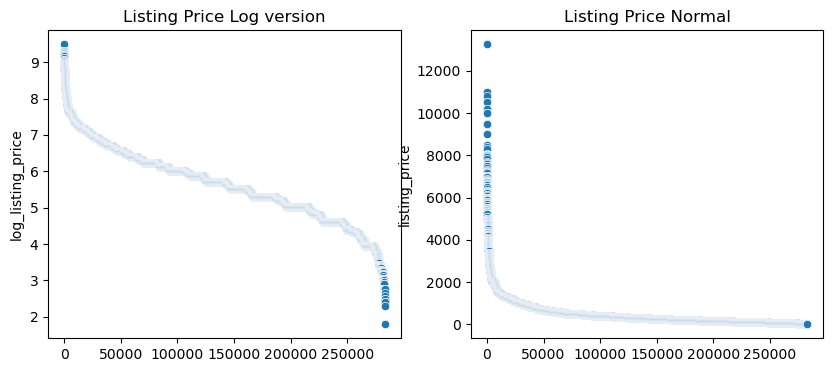

In [88]:
# Dependent variabel distribution + log versioned
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs = axs.flatten()

# Listing price sorted
sns.scatterplot(x=list(range(len(data.df))), y=data.df.sort_values(by='listing_price', ascending=False).log_listing_price, ax=axs[0])
sns.scatterplot(x=list(range(len(data.df))), y=data.df.sort_values(by='listing_price', ascending=False).listing_price, ax=axs[1])
axs[0].set_title('Listing Price Log version')
axs[1].set_title('Listing Price Normal')

plt.show()

# `Regression`

### Reminder of Some of the Basic Regression Assumptions
* Linearity: between the independent variables and the dependent variable
* Independece: Observations are assumed to be independent of each other
* Residuals: Normally distributed, and mean 0
* Multicollinearity: No or very limimted multicollinearity (correlation between independent variables)

The log transformed data will be used as that more closely mimics that of a normal distribution

```markdown 
Since ordinary least squares should enforce close to zero weights for irrelevant featues, we can include all, and see for which it excludes. However, given that some of these values are highly correlated (multicolineratity) some will be excluded in favor of others. These will likely be tested against each other later.

Excluding:
* classified price: My assumption is that this column is some type of classification performed by the company behind the data and is thus is already highly correlated.
* listed_at_date: This is likely not very relevant for pricing, and will be difficult to pass to a model without one-hot encoding the values, that will lead to too sparse vectors.
* user_id: irrelevant for classification. 
* View count is selected over favorites, as it has more variance - these quite correlated as seen below, which makes sense.
* Category_name, subcategory_name, subsubcategory_name: These are all an extension of each other, with each one becomming more and more granular. These are therefore dropped in favor of more granulaity.

```

In [89]:
data.reset_dataset()

In [90]:
# Compute pearson correlation coefficient
correlation = data.df['listing_price'].corr(data.df['classified_price'])
print('Listing -> Classified Price', correlation)


correlation = data.df['viewed_count'].corr(data.df['favourites'])
print('Viewed -> Favorites', correlation)


Listing -> Classified Price 0.9691267746228455
Viewed -> Favorites 0.8068321298641057


In [6]:
# Specify columns for model
columns_to_use = ['classified_id', 'log_listing_price', 'brand_name','condition_name','color_name','subsubsubcategory_name']

# Drop unused columns
data.df = data.df[columns_to_use]

# Print head
data.df.head()

,classified_id,log_listing_price,brand_name,condition_name,color_name,subsubsubcategory_name
0,30343099,7.170120,Air Jordan,Almost as new,Black,Sneakers
1,30346312,5.860786,Ganni,Almost as new,Multi,Skirts
2,30364278,4.795791,One Vintage,Good but used,Multi,Women
3,30406315,6.111467,Ralph Lauren,"New, still with price",Navy,T-shirts
4,30420441,6.398595,Air Jordan,Never used,Beige,Sneakers


In [7]:
# Apply one hot encoding to categorical variables
data.apply_function(pd.get_dummies, columns=data.df.columns[2:])

data.df.head()

,classified_id,log_listing_price,brand_name_& Other Stories,brand_name_(di)vision,brand_name_66 North,brand_name_7 DAYS ACTIVE,brand_name_A.P.C.,brand_name_AF Agger,brand_name_AMI Paris,brand_name_ASICS,...,subsubsubcategory_name_Wallets,subsubsubcategory_name_Wardrobes,subsubsubcategory_name_Watches,subsubsubcategory_name_Weekend bags,subsubsubcategory_name_Wireless speakers,subsubsubcategory_name_Women,subsubsubcategory_name_Yoga,subsubsubcategory_name_iPhone,subsubsubcategory_name_iPhones,subsubsubcategory_name_Øreringe
0,30343099,7.170120,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,30346312,5.860786,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,30364278,4.795791,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,30406315,6.111467,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,30420441,6.398595,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Base Model
Base model using regular regression (i.e. Ordinary Least Squares). As seen in earlier notebooks, we know the data is pretty skewed for its distribution. One consideration could be to transform our distribution using a log transformation

In [8]:
# Base regrsesion model
base_model = LinearRegression()

# Train-test split
X_train, X_test, y_train, y_test = data.stratify_train_test_split(y_column='log_listing_price', val_size=0)

Dependent variable distribution is equal across all subsets


In [9]:
# Fitting model (without classified_id)
base_model.fit(drop_helpers(X_train), y_train)

LinearRegression()

In [10]:
# Accuracy of training set
prediction = base_model.predict(drop_helpers(X_train))
regression_accuracy(prediction, y_train)

# Reversing prediction to original scale
original_scale_predictions = np.exp(prediction)

R2 Score: 0.6185910222046442
MSE: 0.3700668347773154
MAE 0.46619116381013204
RMSE 0.608331188397665


```markdown
Pretty descent R2, and MSE given the complexity of the data
```

Residual Mean (Non-Original Scale) 0.00
Residual Mean (Orignal Scale) 72.87
4979.032885885306
10.235488815412337
13251.0
10.000000000000002


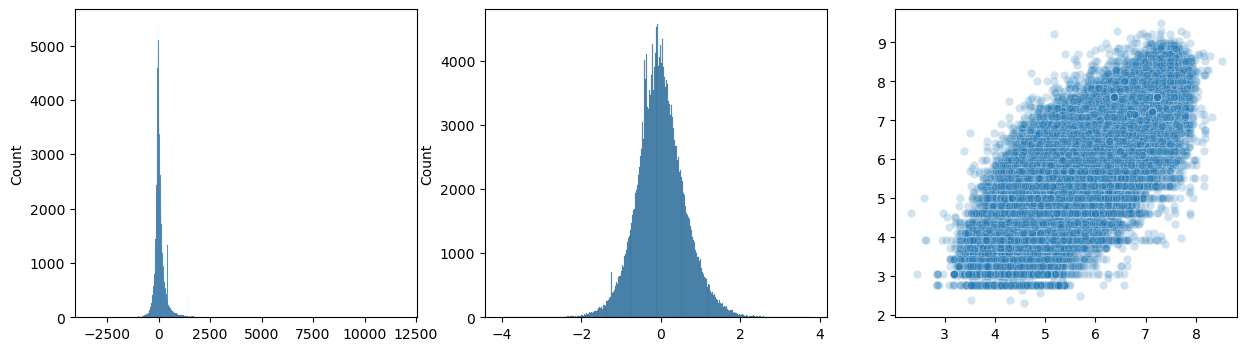

In [11]:
# Residual distribution and Prediction Plots
print(f'Residual Mean (Non-Original Scale) {np.mean(prediction - y_train):.2f}')
print(f'Residual Mean (Orignal Scale) {np.mean(np.exp(y_train) - original_scale_predictions):.2f}')

# Create 3 column figure
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

sns.histplot(np.exp(y_train) - original_scale_predictions, ax=axs[0])
sns.histplot(prediction - y_train, ax=axs[1])
sns.scatterplot(x=prediction, y=y_train, ax=axs[2], alpha=0.2)

# Exclude extreme outliers from histplot
# axs[0].set_xlim(-1000, 1000)


print(max(original_scale_predictions))
print(min(original_scale_predictions))
print(max(np.exp(y_train)))
print(min(np.exp(y_train)))


plt.show()

```markdown
We see the residauls quite closely followed that of a normal distribution with high intensity around 0. For the original scaled predictions, the residuals are similarly very close, with the average prediction being around 70kr's off. From the scatterplot between prediction and actual, their is a clear correlation trend.
```

In [12]:
# Accuracy of training set
original_scale_predictions = np.exp(prediction)

# Adding column to X_training copy
X_train_copy = X_train.copy()
X_train_copy['prediction'] = original_scale_predictions

# 
df0 = data.raw_df.copy()
df0 = df0.merge(X_train_copy[['classified_id','prediction']], on='classified_id')
df0['diff'] = round(df0.prediction - df0.listing_price, 3)

pd.options.display.float_format = '{:.5f}'.format


In [13]:
df0.sort_values(by='diff', ascending=False).head(10)

,classified_id,listed_at_date,user_id,classified_price,listing_price,favourites,viewed_count,brand_name,condition_name,color_name,...,classified_price_standardized,viewed_count_standardized,favourites_standardized,classified_price_normalized,viewed_count_normalized,favourites_normalized,log_listing_price,log_viewed_count,prediction,diff
204863,30533543,2023-09-17,2250701,200,200,0,6,Balenciaga,"New, still with price",Black,...,-0.41854,-0.61537,-0.71178,0.02472,0.00055,0.00000,5.30330,1.94591,3518.03879,3318.03900
217463,30530190,2023-09-16,2250701,200,250,0,70,Balenciaga,"New, still with price",Black,...,-0.41854,-0.00672,-0.71178,0.02472,0.00644,0.00000,5.52545,4.26268,3518.03879,3268.03900
188975,30595788,2023-09-19,1669152,380,500,2,34,Balenciaga,"New, still with price",Black,...,-0.07080,-0.34909,-0.53280,0.04876,0.00313,0.00651,6.21661,3.55535,3518.03879,3018.03900
193133,30532872,2023-09-17,1233726,1200,1200,22,172,Balenciaga,"New, still with price",Brown,...,1.51335,0.96333,1.25695,0.15832,0.01584,0.07166,7.09091,5.15329,4100.69810,2900.69800
66762,31047322,2023-10-11,2396616,600,700,0,8,Louis Vuitton,"New, still with price",Navy,...,0.35422,-0.59635,-0.71178,0.07816,0.00074,0.00000,6.55251,2.19722,3578.64408,2878.64400
78260,31688178,2023-11-12,1202611,800,800,0,11,Louis Vuitton,"New, still with price",Black,...,0.74060,-0.56782,-0.71178,0.10488,0.00101,0.00000,6.68586,2.48491,3586.08501,2786.08500
26599,31332069,2023-10-24,2548205,850,850,1,29,Louis Vuitton,"New, still with price",Black,...,0.83719,-0.39664,-0.62229,0.11156,0.00267,0.00326,6.74641,3.40120,3586.08501,2736.08500
78543,30979977,2023-10-08,1827015,800,850,20,483,Louis Vuitton,"New, still with price",Black,...,0.74060,3.92103,1.07798,0.10488,0.04447,0.06515,6.74641,6.18208,3586.08501,2736.08500
35998,31865624,2023-11-23,2342685,635,635,0,2,Louis Vuitton,"New, still with price",Black,...,0.42183,-0.65341,-0.71178,0.08283,0.00018,0.00000,6.45520,1.09861,3346.09438,2711.09400
115083,30459549,2023-09-13,1079448,250,250,2,10,Céline,Almost as new,White,...,-0.32195,-0.57733,-0.53280,0.03140,0.00092,0.00651,5.52545,2.39790,2925.03561,2675.03600


#### `Test Evaluation`
Evaluating base model on test set

In [14]:
# Perform prediction on test
prediction = base_model.predict(drop_helpers(X_test))
regression_accuracy(prediction, y_test)
print(f'Min: {min(prediction)}, Max: {max(prediction)}')
# There are clearly some extremes in the prediction

R2 Score: -9.272664405856313e+19
MSE: 8.934010025484394e+19
MAE 74549647.9703986
RMSE 9451989222.107903
Min: -1974534774200.3767, Max: 713296222356.9127


```markdown
Moving into the test data, we see that the model has severely overfitted to the training data, and haven't been able to generalize onto the test set
```

In [15]:
# Accuracy of training set
original_scale_predictions = np.exp(prediction)

# Adding column to X_testing copy
X_test_copy = X_test.copy()
X_test_copy['prediction'] = original_scale_predictions

# 
df0 = data.raw_df.copy()
df0 = df0.merge(X_test_copy[['classified_id','prediction']], on='classified_id')
df0['diff'] = round(df0.prediction - df0.listing_price, 3)

/var/folders/v_/xl6xsh6x00990b93wzxm2j8c0000gn/T/ipykernel_98388/3629056761.py:2: RuntimeWarning: overflow encountered in exp
  original_scale_predictions = np.exp(prediction)


In [16]:
# Exclude extreme outliers and computing regression accuracy
df0.sort_values(by='diff', ascending=False).head(10)

,classified_id,listed_at_date,user_id,classified_price,listing_price,favourites,viewed_count,brand_name,condition_name,color_name,...,classified_price_standardized,viewed_count_standardized,favourites_standardized,classified_price_normalized,viewed_count_normalized,favourites_normalized,log_listing_price,log_viewed_count,prediction,diff
24043,30652096,2023-09-23,2565583,150,150,1,12,Reebok,"New, still with price",NaN,...,-0.51514,-0.55831,-0.62229,0.01804,0.00110,0.00326,5.01728,2.56495,inf,inf
48422,31204819,2023-10-18,264626,485,600,25,387,Hay,Good but used,Black,...,0.13205,3.00804,1.52541,0.06279,0.03563,0.08143,6.39859,5.96101,inf,inf
25795,30566434,2023-09-18,688014,600,1000,1,11,Unassigned_Chandeliers,Almost as new,Gold,...,0.35422,-0.56782,-0.62229,0.07816,0.00101,0.00326,6.90875,2.48491,inf,inf
22700,31290331,2023-10-22,1689161,59,100,8,92,Unassigned_Yoga,Good but used,Black,...,-0.69094,0.20251,0.00412,0.00588,0.00847,0.02606,4.61512,4.53260,inf,inf
33819,31102378,2023-10-14,2443147,2200,2500,3,12,Unassigned_Android,Almost as new,Black,...,3.44525,-0.55831,-0.44331,0.29192,0.00110,0.00977,7.82445,2.56495,inf,inf
29631,31888104,2023-11-25,2603341,100,100,0,5,Unassigned_Tablets & Accessories,"New, still with price",NaN,...,-0.61173,-0.62488,-0.71178,0.01136,0.00046,0.00000,4.61512,1.79176,4859.09462,4759.09500
51688,30690191,2023-09-24,2566870,160,160,4,125,Balenciaga,"New, still with price",Black,...,-0.49582,0.51635,-0.35383,0.01937,0.01151,0.01303,5.08140,4.83628,3347.69988,3187.70000
14354,31814454,2023-11-20,1934231,399,399,3,25,Louis Vuitton,"New, still with price",Navy,...,-0.03410,-0.43468,-0.44331,0.05130,0.00230,0.00977,5.99146,3.25810,3578.64408,3179.64400
24100,31001346,2023-10-09,1233223,100,100,4,18,Unassigned_Cots,Almost as new,NaN,...,-0.61173,-0.50125,-0.35383,0.01136,0.00166,0.01303,4.61512,2.94444,2794.91876,2694.91900
11406,31230161,2023-10-20,2070492,1100,1100,5,85,Louis Vuitton,"New, still with price",NaN,...,1.32016,0.13594,-0.26434,0.14496,0.00783,0.01629,7.00397,4.45435,3591.34192,2491.34200


In [17]:
# Exclude extreme outliers and computing regression accuracy
pred_ = df0[abs(df0['diff']) < 1000]['prediction'].values
listing_ = df0[abs(df0['diff']) < 1000]['listing_price'].values

regression_accuracy(pred_, listing_)

R2 Score: 0.633475414374153
MSE: 50217.504654835146
MAE 148.86604777497658
RMSE 224.09262516833334


<Axes: xlabel='diff', ylabel='Count'>

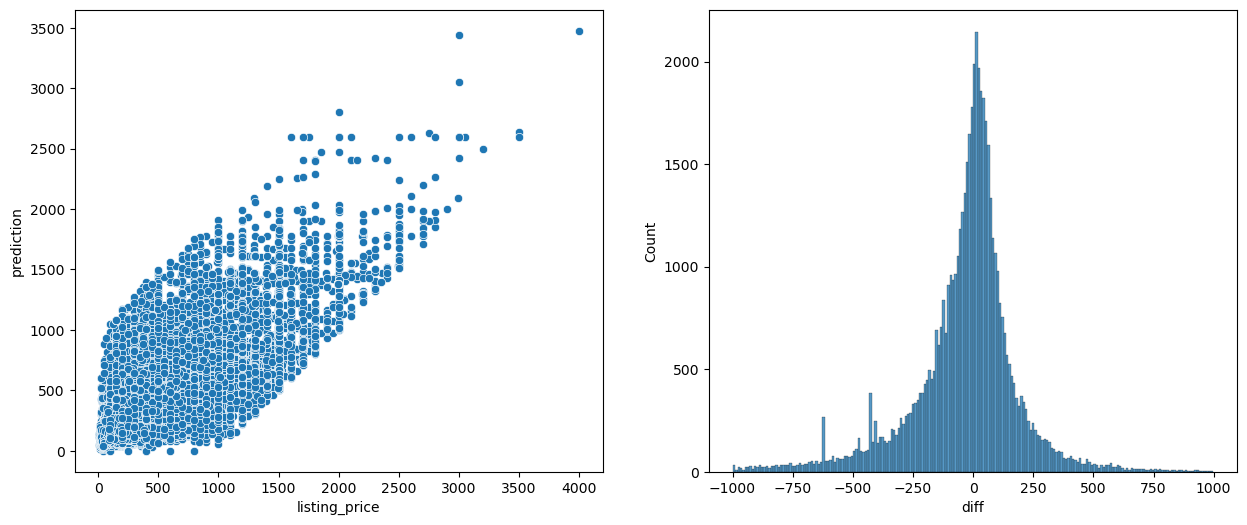

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Scatterplot of prediction vs listing price
sns.scatterplot(x=df0[abs(df0['diff']) < 1000].listing_price, y=df0[abs(df0['diff']) < 1000].prediction, ax=axs[0])

# Residual distribution
sns.histplot(df0[abs(df0['diff']) < 1000]['diff'], ax=axs[1])

# It's clear that the model is able to extract some information from the data, but it's still not very accurate considering above

```markdown
Interesting, when looking into the data we see the very wrong predictions are caused by a handful of predictions. It's likely that these vary too much in this data set as compared to the training set making it difficult for the model to infer anything for these listings. When excluding some of the extreme predictions, the correlation remains relatively similar as to the training data.
```

In [19]:
# Feature importance for base model

# Get the coefficients of the base model
coefficients = base_model.coef_

# Get the column names
column_names = drop_helpers(X_train).columns

# Create a dataframe to store the feature importance
feature_importance = pd.DataFrame({'Feature': column_names, 'Importance': coefficients})

feature_importance.sort_values(by='Importance', ascending=False).head(20)

,Feature,Importance
521,brand_name_Unassigned_Golf,2235877491502.90137
701,brand_name_Unassigned_Straighteners,2181317823507.00220
1054,subsubsubcategory_name_Musikinstrumenter,1749588155526.39404
1162,subsubsubcategory_name_Strollers,1671599715595.31958
1046,subsubsubcategory_name_Miscellaneous chairs,1500962490608.53857
428,brand_name_Unassigned_Brio,1356227425540.45093
722,brand_name_Unassigned_Tennis,1351432159018.57544
557,brand_name_Unassigned_Kitchen knives,1347846596119.61987
1209,subsubsubcategory_name_Vandsport,1346939109102.32983
1109,subsubsubcategory_name_Programs & softwares,1300899093667.16748


```markdown
Coefficients are completely off, and very extreme
```

#### Evaluating extereme predictions
```markdown
We'll be looking into coefficients for extereme predictions to see which are off
```

In [20]:
# Looking into most extreme predictions
X_test['scaled_listing_price'] = prediction
X_test['prediction'] = np.exp(prediction)
X_test['difference'] = X_test.prediction - np.exp(y_test)

(X_test.sort_values(by='difference', ascending=False).iloc[0, 1:-3] * coefficients).sort_values(ascending=False).head(20)

/var/folders/v_/xl6xsh6x00990b93wzxm2j8c0000gn/T/ipykernel_98388/3418446336.py:3: RuntimeWarning: overflow encountered in exp
  X_test['prediction'] = np.exp(prediction)


brand_name_Unassigned_Chandeliers   620740076188.67468
condition_name_Almost as new         16416297130.71645
color_name_Gold                                0.12219
brand_name_& Other Stories                    -0.00000
color_name_Grey                                0.00000
color_name_Navy                               -0.00000
color_name_Multi                              -0.00000
color_name_Mint                               -0.00000
color_name_Metallic                            0.00000
color_name_Light grey                          0.00000
color_name_Light blue                         -0.00000
color_name_Green                               0.00000
color_name_Orange                             -0.00000
color_name_Burgundy                           -0.00000
color_name_Brown                               0.00000
color_name_Blue                                0.00000
color_name_Black                              -0.00000
color_name_Beige                               0.00000
color_name

In [21]:
(X_test.sort_values(by='difference', ascending=False).iloc[0, 1:-3] * coefficients).sort_values(ascending=False).head(20)

brand_name_Unassigned_Chandeliers   620740076188.67468
condition_name_Almost as new         16416297130.71645
color_name_Gold                                0.12219
brand_name_& Other Stories                    -0.00000
color_name_Grey                                0.00000
color_name_Navy                               -0.00000
color_name_Multi                              -0.00000
color_name_Mint                               -0.00000
color_name_Metallic                            0.00000
color_name_Light grey                          0.00000
color_name_Light blue                         -0.00000
color_name_Green                               0.00000
color_name_Orange                             -0.00000
color_name_Burgundy                           -0.00000
color_name_Brown                               0.00000
color_name_Blue                                0.00000
color_name_Black                              -0.00000
color_name_Beige                               0.00000
color_name

In [22]:
(X_train.iloc[:, 3:-3].sum(axis=0)- X_test.iloc[:, 3:-3].sum(axis=0)).sort_values(ascending=True).head(20)

brand_name_Unassigned_Shelving systems         -2.00000
brand_name_Unassigned_TV tables                -2.00000
brand_name_Unassigned_Garbage cans             -1.00000
brand_name_Unassigned_Sports jackets           -1.00000
brand_name_Unassigned_Falsh eyelashes          -1.00000
brand_name_Unassigned_Furniture                -1.00000
subsubsubcategory_name_Chandeliers             -1.00000
subsubsubcategory_name_Tablets & Accessories   -1.00000
brand_name_Unassigned_Chandeliers              -1.00000
subsubsubcategory_name_Garbage cans            -1.00000
brand_name_Unassigned_Android                  -1.00000
brand_name_Unassigned_Yoga                     -1.00000
subsubsubcategory_name_Android                 -1.00000
subsubsubcategory_name_Furniture                0.00000
subsubsubcategory_name_Cots                     0.00000
brand_name_Unassigned_Cots                      0.00000
brand_name_Unassigned_Curtains                  0.00000
brand_name_Unassigned_Dinner jackets            

```markdown
Conclusion, we see that a some exterme coefficients are throwing the very wrong predictions completely off. The reason for this is that the values OHE appear very little across the dataset. It might be worth ensuring a mininmum threshold of X, or otherwise combine to a 'other' column, so this does not happen
```

### Base Model w/ Fewer Columns
```markdown
As seen above, unnassigned brand was a common denominator amongst the extereme predictions, which was causing some significant errors. Additionally, we'll use less granualar category columns. color_name will also be removes, as i suspect it does have much correlation with price. Lastly, a less granular category type will be used
```

##### Data Preperation for New Base Model

In [23]:
### Since only subsubsub category, color and viewed count can be seen among the top 10 features, we will try to remove the other features and see if the model improves

# Reset dataset
data.reset_dataset()

# New columns to use
columns_to_use = ['classified_id','log_listing_price','listing_price','brand_name','subsubcategory_name']

# Drop unused columns
data.df = data.df[columns_to_use]

# OHE. Will likely lead to too many columns
data.apply_function(pd.get_dummies, columns=['brand_name','subsubcategory_name'])

# Print head
data.df.head()


,classified_id,log_listing_price,listing_price,brand_name_& Other Stories,brand_name_(di)vision,brand_name_66 North,brand_name_7 DAYS ACTIVE,brand_name_A.P.C.,brand_name_AF Agger,brand_name_AMI Paris,...,subsubcategory_name_Skin care,subsubcategory_name_Smartphones & Accessories,subsubcategory_name_Sport,subsubcategory_name_Sports shoes,subsubcategory_name_Sportsudstyr,subsubcategory_name_Sportswear,subsubcategory_name_Til drenge,subsubcategory_name_Til piger,subsubcategory_name_Toys,subsubcategory_name_Women
0,30343099,7.17012,1299,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,30346312,5.86079,350,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,30364278,4.79579,120,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,30406315,6.11147,450,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,30420441,6.39859,600,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
# Evaluating frequency of subsubcategory_name
data.df[[col for col in data.df.columns if 'subsubcategory_name' in col]].sum(axis=0).sort_values(ascending=True).head(20)

subsubcategory_name_Sportsudstyr                     20
subsubcategory_name_Toys                             77
subsubcategory_name_Sports shoes                    208
subsubcategory_name_Furniture                       231
subsubcategory_name_Smartphones & Accessories       574
subsubcategory_name_Makeup                          840
subsubcategory_name_Sport                          1217
subsubcategory_name_Skin care                      1374
subsubcategory_name_Beauty & care                  1429
subsubcategory_name_Kids                           1636
subsubcategory_name_Electronics                    2168
subsubcategory_name_Til piger                      2546
subsubcategory_name_Fragrances                     2658
subsubcategory_name_Sportswear                     3132
subsubcategory_name_Til drenge                     3416
subsubcategory_name_Home                           7371
subsubcategory_name_Accessories                    9485
subsubcategory_name_Men                         

In [25]:
# Sportsudstyr subsubcategory has 20 listings, which is fine


# Using a less granular categroy type shows to not have as many low frequency listings
print(data.df[[col for col in data.df.columns if 'brand' in col]].sum(axis=0).sort_values(ascending=True).head(20))

# Evaluating number of brands with less than 50 listings
print('Columns with sum of only 1:', (data.df[[col for col in data.df.columns if 'brand' in col]].sum(axis=0).sort_values(ascending=True) < 50).sum())

brand_name_Unassigned_Double beds             1
brand_name_Unassigned_Falsh eyelashes         1
brand_name_Unassigned_Yoga                    1
brand_name_Unassigned_Ladies bicycles         1
brand_name_Unassigned_Eyeliner                1
brand_name_Unassigned_Benches                 1
brand_name_Unassigned_Office chairs           1
brand_name_Unassigned_VHS                     1
brand_name_Unassigned_Sofa beds               1
brand_name_Unassigned_Couches                 1
brand_name_Unassigned_Biking shoes            1
brand_name_Unassigned_Miscellaneous beds      1
brand_name_Unassigned_Chandeliers             1
brand_name_Unassigned_Android                 1
brand_name_Unassigned_Lounge chairs           1
brand_name_Unassigned_Sun care                1
brand_name_Unassigned_Fiskeri                 1
brand_name_Unassigned_Programs & softwares    1
brand_name_Unassigned_Body care               1
brand_name_Unassigned_Racing bicycles         1
dtype: int64
Columns with sum of only 1:

In [26]:
# Length of columns
print(f'Old length of columns: ', len(data.df.columns))

# Extracting infrequent brands
infrequent_brands = (data.df[[col for col in data.df.columns if 'brand' in col]].sum(axis=0).sort_values(ascending=True) < 50)
infrequent_brands = infrequent_brands[infrequent_brands == True].index

# Assigning 'other' to brands that are in infrequent_brands
data.df['brand_name_other'] = data.df[infrequent_brands].sum(axis=1)
data.df = data.df.drop(columns=infrequent_brands)

# Length of columns
print(f'New length of columns: ', len(data.df.columns))

Old length of columns:  825
New length of columns:  564


In [27]:
# Printing sum of columns to see if process was successful
data.df.iloc[:, 3:].sum(axis=0).sort_values(ascending=True).head(20)

subsubcategory_name_Sportsudstyr               20
brand_name_Unassigned_Nails & manicure         50
brand_name_Unassigned_Børnebøger               51
brand_name_Unassigned_Outdoor                  52
brand_name_Unassigned_Puzzles                  54
brand_name_Unassigned_Parfumer                 54
brand_name_Unassigned_Other for the kitchen    54
brand_name_Unassigned_Other beauty             56
brand_name_Unassigned_Collectors items         56
brand_name_Unassigned_Rain clothes             56
brand_name_Unassigned_Antiques                 57
brand_name_Unassigned_Galla & brudekjoler      58
brand_name_Unassigned_Other home textiles      58
brand_name_Unassigned_Udklædning               59
brand_name_Unassigned_Nightwear                59
brand_name_Unassigned_Haircare                 63
brand_name_Unassigned_Pantsuits                64
brand_name_Unassigned_Sport                    64
brand_name_Unassigned_Home accessories         65
brand_name_Unassigned_Kids                     65


#### Fitting Model

In [28]:
# Base regrsesion model
new_base_model = LinearRegression()

# Train-test split
X_train, X_test, y_train, y_test = data.stratify_train_test_split(y_column='log_listing_price', val_size=0)

Dependent variable distribution is equal across all subsets


In [29]:
# Fitting model (without classified_id)
new_base_model.fit(drop_helpers(X_train), y_train)

LinearRegression()

In [30]:
# Accuracy of training set
prediction = new_base_model.predict(drop_helpers(X_train))

regression_accuracy(prediction, y_train)
print(max(prediction))
print(min(prediction))


R2 Score: 0.4776686810886426
MSE: 0.5067985001608954
MAE 0.5550597004021153
RMSE 0.7118978158141065
7.486311912536621
2.833012580871582


```Markdown
Slightly inferior results, however, this is not necessarily bad as better genearlization often cause model to fit worse
```

In [31]:
# Accuracy of test set
prediction = new_base_model.predict(drop_helpers(X_test))

regression_accuracy(prediction, y_test)
threshold_accuracy(prediction, y_test)

print('\n\nScaling back to original values')
regression_accuracy(np.exp(prediction), X_test.listing_price)
print(min(np.exp(prediction)))
print(max(np.exp(prediction)))


R2 Score: 0.47696580511288833
MSE: 0.503932045447631
MAE 0.5535740589725087
RMSE 0.7098817122927108
Threshold Accuracy 0.33550016781190933


Scaling back to original values
R2 Score: 0.2964310368716633
MSE: 209233.66998165092
MAE 226.3310788106167
RMSE 457.42067069782814
27.393809014549692
1783.4623823468653


```markdown
Test prediction is a lot better and more similar to the that of training, which proves our efforts worked. We do however not achieve a generally very good accuracy. Will look into coefficients again for test predictions that went wrong
```

In [32]:
# Feature importance for base model
# Get the coefficients of the base model
coefficients = new_base_model.coef_

# Get the column names
column_names = drop_helpers(X_train).columns

# Create a dataframe to store the feature importance
feature_importance = pd.DataFrame({'Feature': column_names, 'Importance': coefficients})

feature_importance.sort_values(by='Importance', ascending=False).head(20)

,Feature,Importance
5,brand_name_AF Agger,-1230022399.71344
67,brand_name_Canada Goose,-1230022399.87120
48,brand_name_Bottega Veneta,-1230022399.87697
165,brand_name_I Blame Lulu,-1230022399.97427
31,brand_name_Balenciaga,-1230022400.00603
296,brand_name_Parajumpers,-1230022400.05200
251,brand_name_Mulberry,-1230022400.06431
88,brand_name_Céline,-1230022400.07171
324,brand_name_Roccamore,-1230022400.10809
235,brand_name_Marni,-1230022400.12716


```markdown
Again, we see extreme coefficients, this time most of which are related to subsub categories. Interestingly we see sportsudsyr in their again, which is one of the less frequent ones in the dataset
```

In [33]:
# Looking into most extreme predictions
X_test['scaled_listing_price'] = prediction
X_test['prediction'] = np.exp(prediction)
X_test['difference'] = X_test.prediction - X_test.listing_price

(X_test.sort_values(by='difference', ascending=False).iloc[0, 2:-3] * coefficients).sort_values(ascending=False)

brand_name_& Other Stories              -0.00000
brand_name_Totême                       -0.00000
brand_name_Tekla                        -0.00000
brand_name_The North Face               -0.00000
brand_name_Tiger of Sweden              -0.00000
                                      ...       
brand_name_Karen By Simonsen            -0.00000
brand_name_Kari Traa                    -0.00000
brand_name_other                        -0.00000
brand_name_Canada Goose        -1230022399.87120
subsubcategory_name_Men        -6844456366.49747
Name: 152152, Length: 561, dtype: float64

In [34]:
# New extreme prediction
(X_test.sort_values(by='difference', ascending=False).iloc[3, 2:-3] * coefficients).sort_values(ascending=False)

brand_name_& Other Stories            -0.00000
brand_name_Totême                     -0.00000
brand_name_Tekla                      -0.00000
brand_name_The North Face             -0.00000
brand_name_Tiger of Sweden            -0.00000
                                    ...       
brand_name_Kaffe                      -0.00000
brand_name_Kappa                      -0.00000
brand_name_other                      -0.00000
brand_name_Mulberry          -1230022400.06431
subsubcategory_name_Women    -6844456366.53954
Name: 197083, Length: 561, dtype: float64

We're seeing very exterme predictions for certain brands. Lets try and encode these differently

### Alternative Encoding Methods

Given the extereme coefficients in earlier attempts, this time we'll try a different encoding method than OHE. More details and reasoning are provided below

* Condition Name: This categorical column already follows a natural progressing scale, i.e.: Shabby -> Good, but used -> Almost as new -> Never Used -> New, still with price. Therefore, rather than one-hot encode these, we will try and ordinal encoding based on the order provided 


In [91]:
data.reset_dataset()

# Ordinal Encoding for condition, since this typically follows some sort of order
condition_name = ['Shabby', 'Good but used','Almost as new', 'Never used', 'New, still with price']

# Encoding brands so most popular brands have the highest and vice versa. This is not the most appropriate method, as some brands are likely equal in price, and a better representation, taking in context could be used
brand_encoding = data.df.groupby('brand_name').agg({'log_listing_price': 'mean'}).sort_values(by='log_listing_price', ascending=True).to_dict()['log_listing_price']

# Dataframe
data.raw_df.iloc[:, :14].head()

,classified_id,listed_at_date,user_id,classified_price,listing_price,favourites,viewed_count,brand_name,condition_name,color_name,category_name,subcategory_name,subsubcategory_name,subsubsubcategory_name
0,30343099,2023-09-06,2425635,900,1299,10,145,Air Jordan,Almost as new,Black,Men,Men,Men,Sneakers
1,30346312,2023-09-06,144602,225,350,12,119,Ganni,Almost as new,Multi,Women,Women,Clothes,Skirts
2,30364278,2023-09-07,2028837,120,120,38,209,One Vintage,Good but used,Multi,Women,Women,Women,Women
3,30406315,2023-09-10,1953400,450,450,5,41,Ralph Lauren,"New, still with price",Navy,Men,Men,Clothes,T-shirts
4,30420441,2023-09-11,2202926,500,600,14,208,Air Jordan,Never used,Beige,Men,Men,Men,Sneakers


In [92]:
# Applying encoding (+1 to avoid 0)
data.df['brand_name'] = data.df['brand_name'].apply(lambda x: brand_encoding[x] + 1)
data.df['condition_name'] = data.df['condition_name'].apply(lambda x: condition_name.index(x) +1)


In [93]:
# Mapping rare subsubsubsub categories to 'Other' (those with less than 30 listings or around 0.01%
minimum = 30
print(f'Number of subsubsub categories with less than {minimum} listings:', sum(data.df.subsubsubcategory_name.value_counts() < minimum), ' or ', round(sum(data.df.subsubsubcategory_name.value_counts() < minimum) / len(data.df) * 100, 2), '% of dataset')

rare_sub_categories = pd.DataFrame(data.df.subsubsubcategory_name.value_counts()).where(data.df.subsubsubcategory_name.value_counts() < minimum).dropna().index

Number of subsubsub categories with less than 30 listings: 146  or  0.05 % of dataset


In [94]:
# Replacing with subcategory name
data.df[data.df.subsubsubcategory_name.isin(rare_sub_categories)].subcategory_name.value_counts()

Home             681
Beauty & care    213
Kids             182
Electronics      168
Women            108
Sport            107
Men               57
Name: subcategory_name, dtype: int64

In [95]:
# Applying transformation
data.df.loc[data.df[data.df.subsubsubcategory_name.isin(rare_sub_categories)].index, 'subsubsubcategory_name'] = data.df[data.df.subsubsubcategory_name.isin(rare_sub_categories)].subcategory_name

In [96]:
# Ordinal encoding for subsubsubcategory_name
subsubsubcategory_encoding = data.df.groupby('subsubsubcategory_name').agg({'log_listing_price': 'mean'}).sort_values(by='log_listing_price', ascending=True).to_dict()['log_listing_price']

# Applying encoding
data.df['subsubsubcategory_name'] = data.df['subsubsubcategory_name'].apply(lambda x: subsubsubcategory_encoding[x])

data.df.head()

,classified_id,listed_at_date,user_id,classified_price,listing_price,favourites,viewed_count,brand_name,condition_name,color_name,...,subsubcategory_name,subsubsubcategory_name,classified_price_standardized,viewed_count_standardized,favourites_standardized,classified_price_normalized,viewed_count_normalized,favourites_normalized,log_listing_price,log_viewed_count
0,30343099,2023-09-06,2425635,900,1299,10,145,7.88037,3,Black,...,Men,6.42145,0.93379,0.70656,0.18310,0.11824,0.01335,0.03257,7.17012,4.98361
1,30346312,2023-09-06,144602,225,350,12,119,7.10827,3,Multi,...,Clothes,5.04024,-0.37025,0.45929,0.36207,0.02806,0.01096,0.03909,5.86079,4.78749
2,30364278,2023-09-07,2028837,120,120,38,209,6.16131,2,Multi,...,Women,5.58227,-0.57309,1.31521,2.68875,0.01403,0.01924,0.12378,4.79579,5.34711
3,30406315,2023-09-10,1953400,450,450,5,41,6.70505,5,Navy,...,Clothes,5.42389,0.06443,-0.28251,-0.26434,0.05812,0.00377,0.01629,6.11147,3.73767
4,30420441,2023-09-11,2202926,500,600,14,208,7.88037,4,Beige,...,Men,6.42145,0.16103,1.30570,0.54105,0.06480,0.01915,0.04560,6.39859,5.34233


In [97]:
### Columns used for regression
columns_to_use = ['classified_id','log_listing_price','brand_name','condition_name','subsubsubcategory_name']

# Drop unused columns
data.df = data.df[columns_to_use]

# # OHE. Will likely lead to too many columns
# data.apply_function(pd.get_dummies, columns = ['subsubsubcategory_name'])

# Print head
data.df.head()


,classified_id,log_listing_price,brand_name,condition_name,subsubsubcategory_name
0,30343099,7.17012,7.88037,3,6.42145
1,30346312,5.86079,7.10827,3,5.04024
2,30364278,4.79579,6.16131,2,5.58227
3,30406315,6.11147,6.70505,5,5.42389
4,30420441,6.39859,7.88037,4,6.42145


In [98]:
# Ensuring no too unique columns
data.df.iloc[:, 2:].sum(axis=0).sort_values(ascending=True).head(20)

condition_name            899949.00000
subsubsubcategory_name   1592611.39775
brand_name               1875666.39775
dtype: float64

In [99]:
# Ensuring no too unique columns
data.df.iloc[:, 2:].sum(axis=0).sort_values(ascending=True).head(20)

condition_name            899949.00000
subsubsubcategory_name   1592611.39775
brand_name               1875666.39775
dtype: float64

In [100]:
# Base regrsesion model
new_base_model = LinearRegression()

# Train-test split
X_train, X_test, y_train, y_test = data.stratify_train_test_split(y_column='log_listing_price', val_size=0)

Dependent variable distribution is equal across all subsets


In [101]:
# Fitting model (without classified_id)
new_base_model.fit(drop_helpers(X_train), y_train)

# Accuracy of training set
prediction = new_base_model.predict(drop_helpers(X_train))

print('Accuracy Metrics (Log Scaled)')
regression_accuracy(prediction, y_train)
# Ressidual
print(f'Average Residuals: {np.mean(prediction - y_train):.2f}')
print(f'STD Residuals: {np.std(prediction - y_train):.2f}')

# Accuracy on regular scale
print('\nAccuracy Metrics (Regular Scale)')
regression_accuracy(np.exp(prediction), np.exp(y_train))
print('Max prediction', max(np.exp(prediction)))
print('Min prediction', min(np.exp(y_train)))
# Ressidual
print(f'Average Residuals: {np.mean(np.exp(prediction) - np.exp(y_train)):.2f}')
print(f'STD Residuals: {np.std(np.exp(prediction) - np.exp(y_train)):.2f}')


Accuracy Metrics (Log Scaled)
R2 Score: 0.5452003080918668
MSE: 0.44127509377203356
MAE 0.5159723483016466
RMSE 0.6642854008421633
Average Residuals: 0.00
STD Residuals: 0.66

Accuracy Metrics (Regular Scale)
R2 Score: 0.35385496852795717
MSE: 190892.29358137777
MAE 213.0350925589521
RMSE 436.9122264040888
Max prediction 3013.2497191410293
Min prediction 10.000000000000002
Average Residuals: -85.56
STD Residuals: 428.45


#### Accuracy on Test

In [103]:
# Feature importance for base model
# Get the coefficients of the base model
coefficients = new_base_model.coef_

# Get the column names
column_names = drop_helpers(X_train).columns

# Create a dataframe to store the feature importance
feature_importance = pd.DataFrame({'Feature': column_names, 'Importance': coefficients})

feature_importance.sort_values(by='Importance', ascending=False).head(20)

,Feature,Importance
0,brand_name,0.82390
2,subsubsubcategory_name,0.49927
1,condition_name,0.15292


R2 Score: 0.5452212770709474
MSE: 0.4381693860784058
MAE 0.5134875030165035
RMSE 0.6619436426754213
8.01077441626046
2.9584878746592276
-0.0006116797962555865
0.6619433600590254


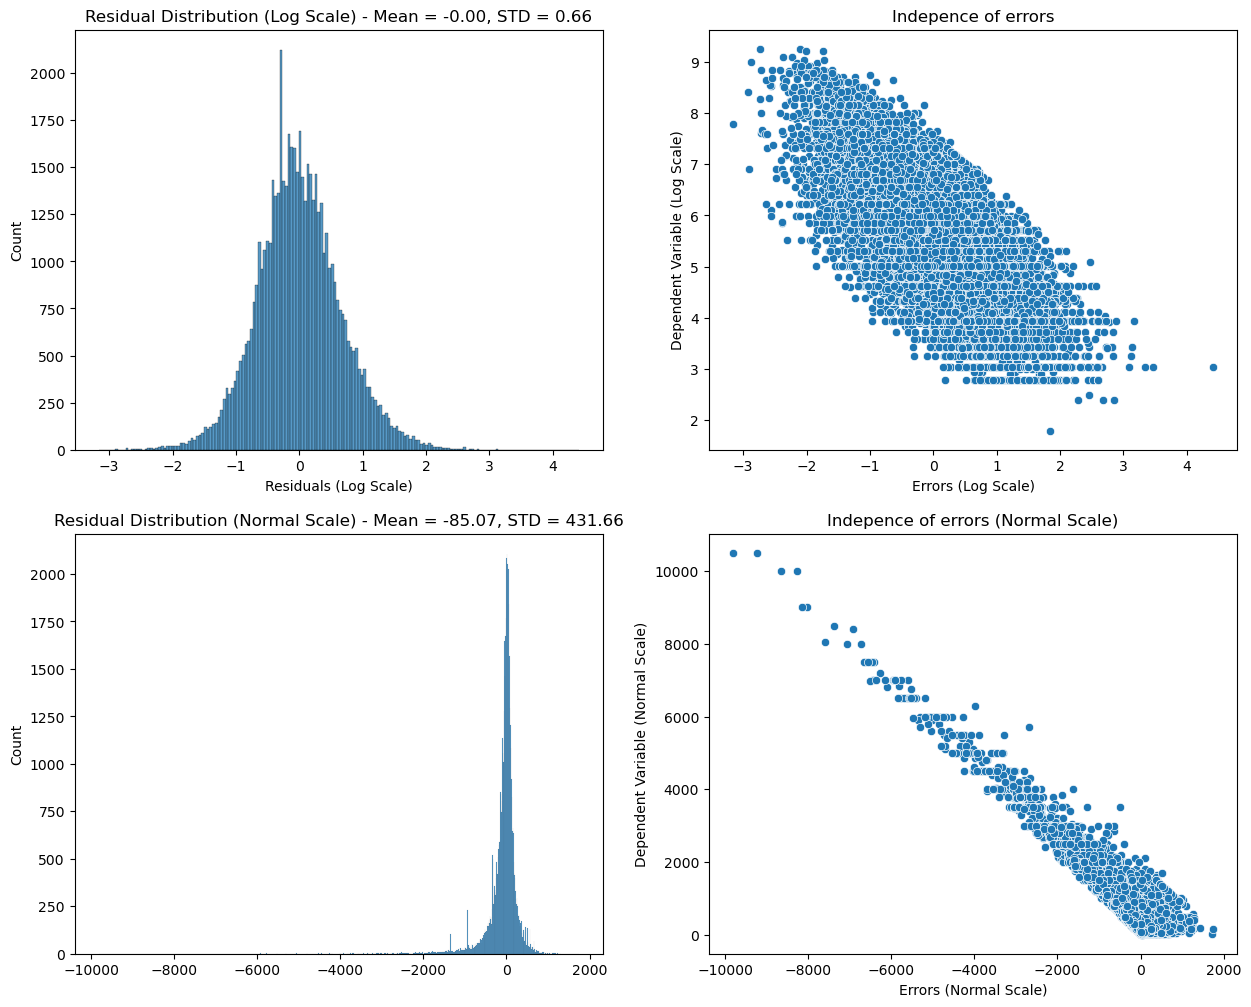

In [109]:
# Accuracy of training set
prediction = new_base_model.predict(drop_helpers(X_test))

regression_accuracy(prediction, y_test)
print(max(prediction))
print(min(prediction))


# Ressidual
print(np.mean(prediction - y_test))
print(np.std(prediction - y_test))

fig, axs = plt.subplots(2,2, figsize=(15, 12))
axs = axs.flatten()
# Residual Distribution
axs[0].set_title(f'Residual Distribution (Log Scale) - Mean = {np.mean(prediction - y_test):.2f}, STD = {np.std(prediction - y_test):.2f}')
axs[0].set_xlabel('Residuals (Log Scale)')
sns.histplot(prediction - y_test, ax=axs[0])

# Residuals vs prediction plot
axs[1].set_title('Indepence of errors')
sns.scatterplot(x=(prediction - y_test), y=y_test, ax=axs[1])
axs[1].set_xlabel('Errors (Log Scale)')
axs[1].set_ylabel('Dependent Variable (Log Scale)')


# Residual Distribution
axs[2].set_title(f'Residual Distribution (Normal Scale) - Mean = {np.mean(np.exp(prediction) - np.exp(y_test)):.2f}, STD = {np.std(np.exp(prediction) - np.exp(y_test)):.2f}')
sns.histplot(np.exp(prediction) - np.exp(y_test), ax=axs[2])
axs[3].set_xlabel('Residuals (Normal Scale)')
axs[3].set_title('Indepence of errors (Normal Scale)')
sns.scatterplot(x=(np.exp(prediction) - np.exp(y_test)), y=np.exp(y_test), ax=axs[3])
axs[3].set_xlabel('Errors (Normal Scale)')
axs[3].set_ylabel('Dependent Variable (Normal Scale)')
plt.show()

### Better than before, but still not great

In [85]:
coefficients = new_base_model.coef_

# Get the column names
column_names = drop_helpers(X_train).columns

# Create a dataframe to store the feature importance
feature_importance = pd.DataFrame({'Feature': column_names, 'Importance': coefficients})

feature_importance.sort_values(by='Importance', ascending=False)

,Feature,Importance
0,brand_name,0.82390
2,subsubsubcategory_name,0.49927
1,condition_name,0.15292


```markdown
This time, it seems coefficients are behaving much more normal, and it seems it's accurately learned to use the brand_name embedding. This is arguably the most reasoanble model, and so far the best performing one.
```


#### Evaluating wrong predictions
```markdown
We see from the residuals how some of predictions are quite alot off. We'll look into what might cause this below

```

In [56]:
# Adding prediction to X_test
X_test['log_listing_price'] = y_test
X_test['log_prediction'] = prediction
X_test['regular_scaled_prediction'] = np.exp(prediction)

In [57]:
# Compute difference between prediction and listing price
X_test['difference_normal_scale'] = abs(X_test['regular_scaled_prediction'] - np.exp(y_test))

In [58]:
# Predictions for regular data
X_test_prediction = data.raw_df.iloc[:, :14].merge(X_test[['classified_id','regular_scaled_prediction', 'difference_normal_scale']], on='classified_id', how='inner')


# Determines percentage the prediction is off
X_test_prediction['percent_off'] = X_test_prediction.regular_scaled_prediction / X_test_prediction.listing_price

X_test_prediction.head()

,classified_id,listed_at_date,user_id,classified_price,listing_price,favourites,viewed_count,brand_name,condition_name,color_name,category_name,subcategory_name,subsubcategory_name,subsubsubcategory_name,regular_scaled_prediction,difference_normal_scale,percent_off
0,30343099,2023-09-06,2425635,900,1299,10,145,Air Jordan,Almost as new,Black,Men,Men,Men,Sneakers,1128.79682,171.20318,0.86897
1,30511575,2023-09-16,1125898,200,200,18,66,One Vintage,Good but used,Army green,Women,Women,Clothes,Tops,106.20604,94.79396,0.53103
2,30346963,2023-09-06,1349247,300,300,4,27,Molo,Almost as new,Multi,Kids,Kids,Til piger,Snow suits,112.60102,188.39898,0.37534
3,30373005,2023-09-08,2160468,850,2000,12,94,BLS Hafnia,Almost as new,Blue,Men,Men,Men,Tops,217.95248,1783.04752,0.10898
4,30442305,2023-09-12,922672,150,200,25,220,One Vintage,Almost as new,NaN,Women,Women,Women,Shoulder bags,219.91195,18.91195,1.09956


In [60]:
# X test prediction sorted by percentage off
X_test_prediction.sort_values(by='percent_off', ascending=False).head(15)[['listing_price', 'brand_name','condition_name', 'subsubsubcategory_name', 'regular_scaled_prediction', 'percent_off']]


,listing_price,brand_name,condition_name,subsubsubcategory_name,regular_scaled_prediction,percent_off
48615,20,Unassigned_Computere,"New, still with price",Computere,1739.37909,86.96895
45118,20,Unassigned_Electronics,"New, still with price",Electronics,670.21440,33.51072
15687,20,Adidas,Good but used,Shoes,592.63425,29.63171
21750,50,Louis Vuitton,Never used,Crossbody bags,1206.77480,24.13550
25752,25,Chanel,"New, still with price",Eau de Toilette,590.52150,23.62086
17002,30,66 North,Almost as new,Belts,707.30155,23.57672
32848,20,Nike,Almost as new,Sneakers,460.24398,23.01220
42042,10,Unassigned_Crossbody bags,Good but used,Crossbody bags,189.16308,18.91631
20735,50,Prada,"New, still with price",Eau de Toilette,912.78048,18.25561
54551,25,Hermès,Almost as new,Ties,442.96052,17.71842


In [67]:
# Exploring Louis Vuitton Crossbody bags predictions and actual listing price
X_test_prediction[(X_test_prediction.brand_name == 'Louis Vuitton') & (X_test_prediction.subsubsubcategory_name == 'Crossbody bags')][['listing_price', 'brand_name','condition_name', 'subsubsubcategory_name', 'regular_scaled_prediction', 'percent_off']].sort_values(by='percent_off', ascending=False).head(15)

,listing_price,brand_name,condition_name,subsubsubcategory_name,regular_scaled_prediction,percent_off
21750,50,Louis Vuitton,Never used,Crossbody bags,1206.77480,24.13550
14120,300,Louis Vuitton,"New, still with price",Crossbody bags,1406.17174,4.68724
15872,1000,Louis Vuitton,Shabby,Crossbody bags,762.76339,0.76276
9302,1500,Louis Vuitton,Almost as new,Crossbody bags,1035.65261,0.69044
14835,1450,Louis Vuitton,Shabby,Crossbody bags,762.76339,0.52604
11141,1800,Louis Vuitton,Good but used,Crossbody bags,888.79575,0.49378
9363,2000,Louis Vuitton,Good but used,Crossbody bags,888.79575,0.44440
6247,2100,Louis Vuitton,Good but used,Crossbody bags,888.79575,0.42324
12309,2950,Louis Vuitton,Almost as new,Crossbody bags,1035.65261,0.35107
14721,3000,Louis Vuitton,Good but used,Crossbody bags,888.79575,0.29627


```Markdown
Looking into prediction where the percentage is off by a lot, we can also see how these listings have very low prices, compared to their category. E.g., the prediction with the higest actual difference is a new, still with price computer, that was predicted at around 1000k. A reasonable prediction taken everything into consideration, however, the actual listing price was 20kr, which is an unlikely case. Moreovr, we see a Louis Vuitton Crossbody Bag for 20kr, where our model predicts around 1.5k - another reasonable prediction, but where the listing price is completely off
```

```Markdown
Taking everything into consideration, it seems that last model is the most supperior performing one, with reasoanble coefficients. Therefore, this model will serve as our baseline model. 
```